## Rolling Betas
### Sesión 3 (18-06-2021)

In [1]:
import pandas_datareader as pdr
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
import seaborn
import warnings
warnings.filterwarnings("ignore")
seaborn.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
%matplotlib inline

In [2]:
# ver todas las bases disponibles de FF en pandas
pdr.famafrench.get_available_datasets()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_OP_Daily',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 'Portfolios_Formed_on_INV_Daily',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portf

In [3]:
# descargar, por ejemplo, 3-factor model
## descarga la data desde 1926 y divide los retornos por 100
factors = pdr.get_data_famafrench('F-F_Research_Data_Factors', start='1-1-1926')[0] / 100

## esto muestra las primeras filas del dataframe
print(factors.head())

## y esto las últimas
print(factors.tail())

         Mkt-RF     SMB     HML      RF
Date                                   
1926-07  0.0296 -0.0230 -0.0287  0.0022
1926-08  0.0264 -0.0140  0.0419  0.0025
1926-09  0.0036 -0.0132  0.0001  0.0023
1926-10 -0.0324  0.0004  0.0051  0.0032
1926-11  0.0253 -0.0020 -0.0035  0.0031
         Mkt-RF     SMB     HML      RF
Date                                   
2020-12  0.0463  0.0481 -0.0136  0.0001
2021-01 -0.0003  0.0719  0.0285  0.0000
2021-02  0.0278  0.0211  0.0708  0.0000
2021-03  0.0308 -0.0248  0.0740  0.0000
2021-04  0.0494 -0.0309 -0.0075  0.0000


In [4]:
# descargar, por ejemplo, industry factors
industries = pdr.get_data_famafrench('10_Industry_Portfolios', start='1-1-1926')[0] / 100
print(industries.head())

          NoDur   Durbl   Manuf   Enrgy   HiTec   Telcm   Shops   Hlth   \
Date                                                                      
1926-07  0.0145  0.1555  0.0469 -0.0118  0.0290  0.0083  0.0011  0.0177   
1926-08  0.0397  0.0368  0.0281  0.0347  0.0266  0.0217 -0.0071  0.0425   
1926-09  0.0114  0.0480  0.0115 -0.0339 -0.0038  0.0241  0.0021  0.0069   
1926-10 -0.0124 -0.0823 -0.0363 -0.0078 -0.0458 -0.0011 -0.0229 -0.0057   
1926-11  0.0520 -0.0019  0.0410  0.0001  0.0471  0.0163  0.0643  0.0542   

          Utils   Other  
Date                     
1926-07  0.0704  0.0216  
1926-08 -0.0169  0.0438  
1926-09  0.0204  0.0029  
1926-10 -0.0263 -0.0285  
1926-11  0.0371  0.0211  


In [5]:
## define una variable endog que es el exceso de retorno del factor energia
## segun la documentación, el factor energia son portfolios construídos con empresas de
## "Oil, Gas, and Coal Extraction and Products"
## factors.RF.values es un array con la risk free en el tiempo
## acá habría que checkear que las fechas sean las mismas en industries y en factors
## para saber que no estamos restando cualquier cosa

## una opción sería correr esto:
assert all(factors.RF.index == industries.index)
## eso va a no hacer nada si todos los indices de factors son iguales a todos los indices
## de industries en la misma posicion y en caso de que alguno no lo sea, va a tirar un error

## volviendo a la variable: lo que está haciendo es tomar el portfolio de sector energía
## y le resta la risk free para tener el exceso de retorno del portfolio

endog = industries.Enrgy - factors.RF.values # variable dependiente (ejemplo, energy sector)

## ahora define las variables independientes: los 3 factores (exceso de retorno del mercado, 
## tamaño (small minus big) y value vs growth (high minus low))
## el metodo "add_constant" lo que hace es agregar una columna de 1 para estimar el beta del intercept

exog = sm.add_constant( factors.loc[:, ['Mkt-RF', 'SMB', 'HML']] ) # factores (en este caso, 3-fama french)

## rolling Ols: esto es una regresión comun y corriente (cuadrados minimos ordinarios)
## pero lo que va haciendo es ajustar sobre una ventana movil:
## en el ejemplo agarras 60 días (esa es tu ventana) y ajustas la regresi+on
## moves la ventana un día y volves a ajustar
## y así vas repitiendo.
## Ejemplo: ajustas del día 1 al 60 en la primer ventana. Despues del 2 al 61. Despues del 3 al 62 y así.
rols = RollingOLS(endog, exog, window = 60) #rolling con window determinado
rres = rols.fit() # ajustar reg

## sacas los parámetros y los mostras
params = rres.params # obtener parametros
print(params.tail())

            const    Mkt-RF       SMB       HML
Date                                           
2020-12 -0.013413  1.381466  0.655304  0.826331
2021-01 -0.015327  1.415510  0.679183  0.780695
2021-02 -0.011569  1.396323  0.687504  0.936513
2021-03 -0.013112  1.383356  0.758697  0.862398
2021-04 -0.014614  1.383135  0.777340  0.829588


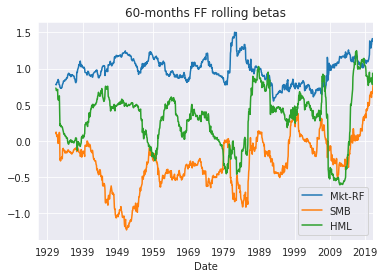

In [6]:
## y acá grafica: podemos ver como van variando esos betas en el tiempo
params = pd.DataFrame(params)
params[['Mkt-RF', 'SMB', 'HML']].plot()
plt.title('60-months FF rolling betas')
plt.show()